In [1]:
%load_ext tensorboard
import os
import sys
sys.path.append(f"{os.environ['base']}Tools")

import btk
import dataset_generators as dgen
import time
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from PIL import Image, ImageDraw
from torch import nn
from torch.utils.tensorboard.writer import SummaryWriter


plt.style.use(f"{os.environ['style']}")

In [ ]:
#Demo
tsx, tsy = dgen.character_spaces(2, dgen.trainfonts)
for x in range(5):
    display(Image.fromarray(tsx[x]))
    display(tsy[x])

In [4]:
trainx, trainy, valx, valy = btk.depickler('data\\trainx-1643204824', 'data\\trainy-1643204824', 'data\\valx-1643204824', 'data\\valy-1643204824')

""" trainx, trainy = dgen.character_spaces(30000, dgen.trainfonts)
valx, valy = dgen.character_spaces(3000, dgen.evalfonts)
num = btk.pickle_set(trainx, trainy, valx, valy) """


trainx, valx = btk.standardize(trainx), btk.standardize(valx)
train = btk.DataGen(trainx, trainy, batch_len=1)
val = btk.DataGen(valx, valy, batch_len=1)
tdata = torch.utils.data.DataLoader(train, batch_size=256, shuffle=True)
vdata = torch.utils.data.DataLoader(val, batch_size=256, shuffle=True)

In [ ]:
class CharSeperator(nn.Module):
    #32 x 12 input -> 16 x 6 -> 8 x 3

    def __init__(self):
        super(CharSeperator, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 2)
        self.conv2 = nn.Conv2d(16, 32, 2)
        self.conv3 = nn.Conv2d(32, 32, 2)
        self.conv4 = nn.Conv2d(32, 64, 2)
        self.conv5 = nn.Conv2d(64, 64, 3)
        self.mpool = nn.MaxPool2d(2, stride=1)
        self.drop = nn.Dropout(0.16)
        self.fc1 = nn.Linear(6144, 2048)
        self.fc2 = nn.Linear(2048, 1024)
        self.fc3 = nn.Linear(1024, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.mpool(x)
        x = self.drop(x)
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = self.mpool(x)
        x = x.view(-1, 64 * 24 * 4)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def train_cycle(epi, tboard_writer):
    current_loss = 0.0
    last_loss = 0.0
    for i, item in enumerate(tdata):
        data, labels = item[0].to('cuda'), item[1].to('cuda')
        opti.zero_grad()
        out = space_model(data)
        loss = loss_fn(out, labels)
        loss.backward()
        opti.step()
        current_loss += loss.item()
        
        if i % 257 == 255:
            last_loss = current_loss / 256
            print(f'Batch: {i} | Loss {round(last_loss, 5)}')
            tboard_x = epi * len(tdata) + i + 1
            tboard_writer.add_scalar('Loss / Batch', last_loss, tboard_x)
            current_loss = 0.0
    return last_loss

def val_cycle():
    current_loss = 0.0
    for i, vitem in enumerate(vdata):
        datav, labelsv = vitem[0].to('cuda'), vitem[1].to('cuda')
        with torch.no_grad():
            out = space_model(datav)
        loss = loss_fn(out, labelsv)
        current_loss += loss
        avg_loss = current_loss / (i + 1)
    return avg_loss

cycle_id = round(time.time())
space_model = CharSeperator().to("cuda")
loss_fn = nn.BCEWithLogitsLoss()
opti = torch.optim.Adam(space_model.parameters(), lr=0.001, weight_decay=1e-5)
writer = SummaryWriter(f'runs/word_segmentation_{cycle_id}')

epoch_number = 0
best = 999999

for epoch in range(6):
    print('EPOCH {}:'.format(epoch_number + 1))

    #Training
    space_model.train(True)
    tloss = train_cycle(epoch_number, writer)
    #Validation
    space_model.train(False)
    vloss = val_cycle()

    #Logging / Maintenance
    print(f'Losses: Train {round(float(tloss), 5)} Validation {round(float(vloss), 5)} Validation Accuracy {round((1 - round(float(vloss), 5)) * 100, 5)}%')
    writer.add_scalars('Training vs. Validation Loss', {'Training':tloss, 'Validation':vloss }, epoch_number + 1)
    writer.flush()
    epoch_number += 1
    if vloss < best:
        best = vloss
        torch.save(space_model.state_dict(), f'space_model_{cycle_id}')
print(best)
print(f'space_model_{cycle_id}')

In [79]:
class CharSeperator(nn.Module):
    #32 x 12 input -> 16 x 6 -> 8 x 3

    def __init__(self):
        super(CharSeperator, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 2)
        self.conv2 = nn.Conv2d(16, 32, 2)
        self.conv3 = nn.Conv2d(32, 32, 2)
        self.conv4 = nn.Conv2d(32, 64, 2)
        self.conv5 = nn.Conv2d(64, 64, 3)
        self.mpool = nn.MaxPool2d(2, stride=1)
        self.drop = nn.Dropout(0.16)
        self.fc1 = nn.Linear(6144, 2048)
        self.fc2 = nn.Linear(2048, 1024)
        self.fc3 = nn.Linear(1024, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.mpool(x)
        x = self.drop(x)
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = self.mpool(x)
        x = x.view(-1, 64 * 24 * 4)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def draw_sep(img, seps):
    ymax = im.size[1]
    for x in seps:
        ImageDraw.Draw(img).line([x, 0, x, ymax], 0, 1)
    return img

def sdetect(img, sdims, sens):
    img = np.array(img)
    slices, idx = btk.img_slicer(img, sdims, 1, 'v')
    slices = [torch.from_numpy(btk.standardize(x)).unsqueeze(0).unsqueeze(0) for x in slices]
    with torch.no_grad():
        preds = [float(torch.sigmoid(space_model(x))) for x in slices]
    for i, x in enumerate(preds):
        if x <= sens:
            preds[i] = 0
    return preds, idx

def row_detect(img, sdims):
    img = np.array(img).T
    dims = img.shape
    cols = [Image.fromarray(img[round(dims[0] * 0.25):round(dims[0] * 0.25) + sdims[0], :]),
            Image.fromarray(img[round(dims[0] * 0.75) - sdims[0]:round(dims[0] * 0.75), :])]
    zsections = []
    for y in cols:
        preds, _ = sdetect(y, (32, 12), 0.8)
        zstart = 0
        for i, x in enumerate(preds):
            if i == 0 or i == len(preds) - 1:
                pass
            if preds[i - 1] > 0 and x == 0:
                zstart = i
            if preds[i - 1] == 0 and x > 0:
                zend = i
                zsections.append((btk.halfpoint(zstart, zend), zend - zstart))
    zsections = sorted(zsections, key=lambda x: x[1], reverse=True)
    rows = [(x[0], round(x[1])) for x in zsections if x[1] >= zsections[0][0] * 0.333]
    rows2 = []
    for i, x in enumerate(rows[::2]):
        if abs(rows[i + 1][0] - x[0]) <= (dims[1] * 0.07):
            rows2.append((round((x[0] + rows[i + 1][0]) / 2) + 6, round((x[1] + rows[i + 1][1]) / 1.333)))
    return rows2

def grouper(inp: list, min=2, dist=2):
    inp.sort()
    last = 0
    vals = []
    confirmed = []
    for x in inp:
        if x - last >= dist:
            vals.append(last)
            if len(vals) >= min:
                confirmed.append(round(sum(vals) / len(vals)))
            vals = []
            last = x
        else:
            vals.append(last)
            last = x
    return confirmed

def find_spaces(img, sens=0.8):
    iar = np.array(img)
    row_pos = row_detect(img, (32, 12))
    rows = [iar[round(x[0] - (x[1] / 2)):round(x[0] + (x[1] / 2))] for x in row_pos]
    final = []
    for i in rows:
        im = Image.fromarray(btk.fit2dims((32, 12), i))
        images = btk.img_splitter(im, im.size, (32, 12))
        sums = []
        for z in images:
            im = Image.fromarray(z)
            preds, idx = sdetect(im, (32, 12), sens)
            crits = btk.criticals(preds, [btk.halfpoint(x[0], x[1]) for x in idx])
            crits = [x[0] - 1 for x in crits if x[1] == 'max']
            sums.extend(crits)
        im = Image.fromarray(btk.fit2dims((32, 12), i))
        final.append((grouper(sums), im))
        #draw_sep(im, grouper(sums))
        #display(im.resize((im.size[0] * 3, im.size[1] * 3)))
    return final

def chopper(ipack):
    fpack = []
    for x in ipack:
        img = np.array(x[1])
        if x[0][-1] - len(img[0]) >= 32:
            x[0].append(x[0][-1] + 32)
        else:
            x[0].append(len(img[0]) - 1)
        cpack = []
        for i, y in enumerate(x[0]):
            if i == len(x[0]) - 1:
                break
            cpack.append(Image.fromarray(img[:, y:x[0][i + 1]]))
        fpack.append(cpack)
    return fpack

space_model = CharSeperator()
space_model.load_state_dict(torch.load("models\\space_model_1643239106"))
space_model.eval()

CharSeperator(
  (conv1): Conv2d(1, 16, kernel_size=(2, 2), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1))
  (conv3): Conv2d(32, 32, kernel_size=(2, 2), stride=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
  (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (mpool): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout(p=0.16, inplace=False)
  (fc1): Linear(in_features=6144, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=1, bias=True)
)

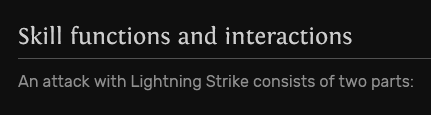

In [94]:
with Image.open("testimgs\\t16.png") as f:
    iar = btk.grey_np(f)[50:250, :]
im = Image.fromarray(iar)
display(im)

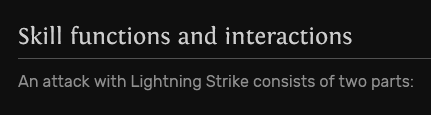

C:\Users\BBA\Coding\Tools\btk.py:128: RuntimeWarning: invalid value encountered in true_divide
  return np.array((data - np.mean(data)) / np.std(data), dtype='float32')


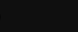

In [95]:
with Image.open("testimgs\\t16.png") as f:
    iar = btk.grey_np(f)[50:250, :]
im = Image.fromarray(iar)
display(im)

chars = chopper(find_spaces(im, 0.666))
for x in chars:
    for y in x:
        display(y)

Sliced image shape (32, 157)


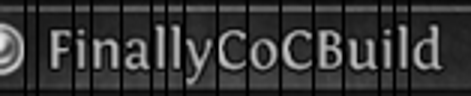

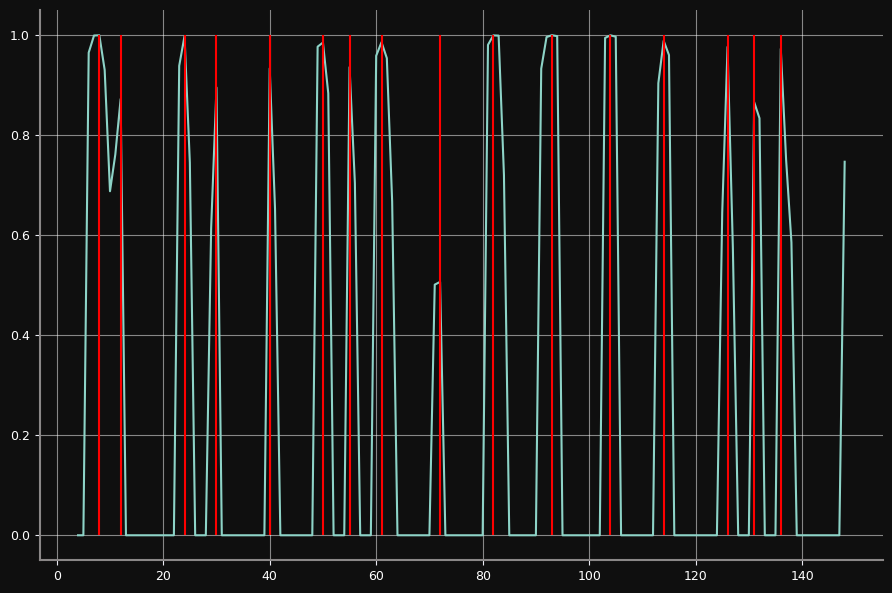

In [191]:
with Image.open("testimgs\\t27.png") as f:
    iar = btk.grey_np(f)
im = Image.fromarray(iar)

crits, im, preds = sdetect(im, (32, 12))
draw_sep(im, crits)
display(im.resize((471, 96)))

fig = plt.figure()
ax = plt.axes()
plt.plot(range(4, len(preds) + 4), preds)
plt.vlines(crits, 0, 1, colors='r')
plt.show()

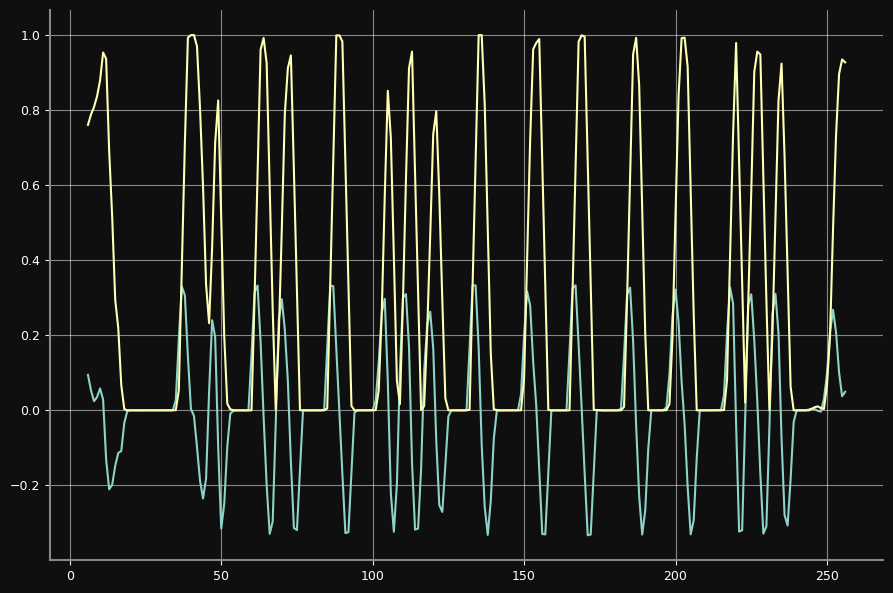

In [34]:
fig = plt.figure()
ax = plt.axes()
plt.plot(range(4, len(preds) + 4), preds)
plt.vlines(crits, 0, 1, colors='r')
plt.plot(btk.diff_compress(idx), btk.smooth_avg(np.gradient(grads)))
plt.plot(btk.diff_compress(idx), btk.smooth_avg(grads))
plt.plot(btk.diff_compress(idx), btk.smooth_avg(preds))
plt.show()
display(drawn.size)
display(drawn.resize((drawn.size[0] * 2, drawn.size[1] * 2)))